## Installations

- !pip install sumeval
- !pip install spacy
- !python -m spacy download en

In [1]:
## for text recognition
import nltk
import string
import json

## for general studies
import os as os
from os import listdir
from os.path import isfile, join
import glob
from numpy import fft as fft
import matplotlib.pyplot as plt
import numpy as np
import sys
import seaborn as sns
from tqdm import tqdm
import time as time
import multiprocessing as mp

## My codes
from src.utils import wer
from src.utils import SoundToText

## settings
%matplotlib inline

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [20]:
print("number of total CNN", len(glob.glob("Data/Text/cnn/stories/*.story")))

number of total CNN 92579


In [18]:
# ## sample a subset of CNN news
# np.random.seed(42)
# for i in glob.glob("Data/Text/cnn/stories/*.story"):
#     if np.random.random() < 0.1:
#         os.system('cp ' + i + " " + i.replace("stories", "temp"))

In [22]:
# ## sample a subset of CNN news
# np.random.seed(42)
# for i in glob.glob("Data/Text/cnn/temp/*.story"):
#     sample_rand = np.random.random()
#     if sample_rand < 0.1:
#         os.system('mv ' + i + " " + i.replace("temp", "test"))
#     elif sample_rand < 0.2:
#         os.system('mv ' + i + " " + i.replace("temp", "val"))
#     else:
#         os.system('mv ' + i + " " + i.replace("temp", "train"))

In [24]:
print("number of total train", len(glob.glob("Data/Text/cnn/train/*.story")))
print("number of total test", len(glob.glob("Data/Text/cnn/test/*.story")))
print("number of total val", len(glob.glob("Data/Text/cnn/val/*.story")))

number of total train 7031
number of total test 964
number of total val 1290


In [19]:
from sumeval.metrics.rouge import RougeCalculator
from sumeval.metrics.bleu import BLEUCalculator

rouge = RougeCalculator(stopwords=True, lang="en")

rouge_1 = rouge.rouge_n(
            summary="I went to the Mars from my living town.",
            references="I went to Mars",
            n=1)

rouge_2 = rouge.rouge_n(
            summary="I went to the Mars from my living town.",
            references=["I went to Mars", "It's my living town"],
            n=2)

rouge_l = rouge.rouge_l(
            summary="I went to the Mars from my living town.",
            references=["I went to Mars", "It's my living town"])

# You need spaCy to calculate ROUGE-BE

rouge_be = rouge.rouge_be(
            summary="I went to the Mars from my living town.",
            references=["I went to Mars", "It's my living town"])


bleu = BLEUCalculator()
score = bleu.bleu("I am waiting on the beach",
                  "He is walking on the beach")

print("ROUGE-1: {}, ROUGE-2: {}, ROUGE-L: {}, ROUGE-BE: {}, BLUE: {}".format(
    rouge_1, rouge_2, rouge_l, rouge_be, score).replace(", ", "\n"))

ROUGE-1: 0.5
ROUGE-2: 0.4
ROUGE-L: 0.6666666666666666
ROUGE-BE: 0.4
BLUE: 11.362193664674995


In [20]:
import spacy
nlp = spacy.load('en')

# Explore data cleaning and LDA

#### See: https://www.machinelearningplus.com/nlp/topic-modeling-python-sklearn-examples/#13compareldamodelperformancescores

#### Summarization in general:
https://github.com/icoxfog417/awesome-text-summarization

#### open MNT: https://github.com/OpenNMT/OpenNMT-py#features

## The goal is to get key topics and key words of a given text

- !pip install pyLDAvis
- !pip install gensim

In [1]:
import numpy as np
import pandas as pd
import re, nltk, spacy, gensim, string
from nltk.corpus import stopwords
from collections import Counter

# Sklearn
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from sklearn.model_selection import GridSearchCV
from pprint import pprint


# Plotting tools
import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
%matplotlib inline

Load text

In [2]:
# A custom function to clean the text before sending it into the vectorizer
def cleanText(text):
    
    table = str.maketrans('', '', string.punctuation)
    # get rid of punctuation
    text = text.translate(table)
    
    # get rid of newlines
    text = text.strip().replace("\n", " ").replace("\r", " ")
    
    # replace twitter @mentions
    mentionFinder = re.compile(r"@[a-z0-9_]{1,15}", re.IGNORECASE)
    text = mentionFinder.sub("@MENTION", text)
    
    # replace HTML symbols
    text = text.replace("&amp;", "and").replace("&gt;", ">").replace("&lt;", "<")
    
    # lowercase
    text = text.lower()

    return text

In [3]:
# Initialize spacy 'en' model
nlp = spacy.load('en')

In [14]:
text = []
sumtext = []
for i in range(1):
    with open('Data/NPR/' + str(i) + '_trans.txt', 'r') as myfile:
        text.append(cleanText(myfile.read()))
    with open('Data/NPR/' + str(i) + '.txt', 'r') as myfile:
        sumtext.append(cleanText(myfile.read()))
# Convert to list, now text is a list
data = nlp("".join(text))
sumdata = nlp("".join(sumtext))
print(data[:20])

i just wish to congratulate couples friends yeah congratulation really unfortunate that of a smile or my gordon is morning


In [15]:
def calc_score(ref, comp, debug=False):
    '''gives the number of items in ref that is also found in comp'''
    ## check if it is a list of strings
    if not isinstance(ref, list):
        ref = str(ref).split()
    if not isinstance(comp, list):
        comp = str(comp).split()
        
    s_ref = set(ref)
    s_comp = set(comp)
    s_inter = s_comp.intersection(s_ref)
    if debug:
        print(s_ref)
        print(s_comp)
        print(s_inter)
    return len(s_inter)/len(s_ref)

## calculate the maximum score
print(calc_score(ref=sumdata, comp=data))

0.7804878048780488


In [16]:
## calculate the maximum score
token = lemming(data)
sumtoken = lemming(sumdata)
print(calc_score(ref=sumtoken, comp=token, debug=False))

0.7894736842105263


In [17]:
## baseline; hot words score; do half or target words for now
print(len(sumtoken))
length = len(sumtoken)//2
word_freq = Counter(token)
common_words = [w[0] for w in word_freq.most_common(length)]
print(common_words)
print(calc_score(ref=sumtoken, comp=common_words, debug=False))

19
['u', 'president', 'today', 'policy', 'week', 'leader', 'pope', 'john', 'weekend']
0.21052631578947367


In [18]:
vectorizer = CountVectorizer(analyzer='word',       
                             min_df=1,                        # minimum reqd occurences of a word 
                             token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3
                             # max_features=50000,             # max number of uniq words
                            )

In [19]:
token_vec = vectorizer.fit_transform(token)
#sumtoken_vec = vectorizer.fit_transform(sumtoken)

In [377]:
# Materialize the sparse data
token_dense = token_vec.todense()

# Compute Sparsicity = Percentage of Non-Zero cells
print("Sparsicity: ", ((token_dense > 0).sum()/token_dense.size)*100, "%")

Sparsicity:  0.028204332485 %


In [257]:
# Build LDA Model
lda_model = LatentDirichletAllocation(n_components=20,           # Number of topics
                                      max_iter=10,               # Max learning iterations
                                      learning_method='online',   
                                      random_state=100,          # Random state
                                      batch_size=128,            # n docs in each learning iter
                                      evaluate_every = -1,       # compute perplexity every n iters, default: Don't
                                      n_jobs = -1,               # Use all available CPUs
                                     )
lda_output = lda_model.fit_transform(token_vec)

print(lda_model)  # Model attributes

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=20, n_jobs=-1, n_topics=None, perp_tol=0.1,
             random_state=100, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)


In [258]:
# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda_model.score(token_vec))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_model.perplexity(token_vec))

# See model parameters
pprint(lda_model.get_params())

Log Likelihood:  -96122.669174
Perplexity:  7050.58253312
{'batch_size': 128,
 'doc_topic_prior': None,
 'evaluate_every': -1,
 'learning_decay': 0.7,
 'learning_method': 'online',
 'learning_offset': 10.0,
 'max_doc_update_iter': 100,
 'max_iter': 10,
 'mean_change_tol': 0.001,
 'n_components': 20,
 'n_jobs': -1,
 'n_topics': None,
 'perp_tol': 0.1,
 'random_state': 100,
 'topic_word_prior': None,
 'total_samples': 1000000.0,
 'verbose': 0}


In [259]:
# Define Search Param
search_params = {'n_components': [10, 20, 30], 'learning_decay': [.5, .7, .9]}

# Init the Model
lda = LatentDirichletAllocation(learning_method='online')

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(token_vec)

GridSearchCV(cv=None, error_score='raise',
       estimator=LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=10, n_jobs=1, n_topics=None, perp_tol=0.1,
             random_state=None, topic_word_prior=None,
             total_samples=1000000.0, verbose=0),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_components': [10, 20, 30], 'learning_decay': [0.5, 0.7, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [260]:
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(token_vec))

Best Model's Params:  {'learning_decay': 0.9, 'n_components': 10}
Best Log Likelihood Score:  -46821.9666206
Model Perplexity:  5442.72975841


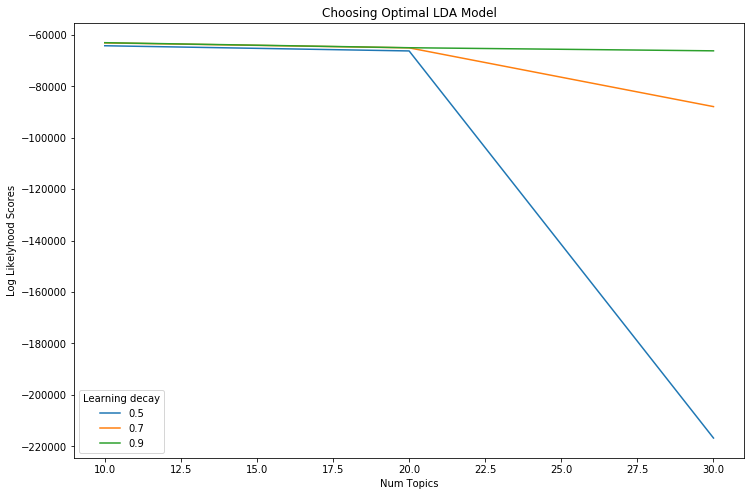

In [262]:
# Get Log Likelyhoods from Grid Search Output
n_topics = [10, 20, 30]
log_likelyhoods_5 = model.cv_results_['mean_train_score'][model.cv_results_['param_learning_decay'] == 0.5]
log_likelyhoods_7 = model.cv_results_['mean_train_score'][model.cv_results_['param_learning_decay'] == 0.7]
log_likelyhoods_9 = model.cv_results_['mean_train_score'][model.cv_results_['param_learning_decay'] == 0.9]

# Show graph
plt.figure(figsize=(12, 8))
plt.plot(n_topics, log_likelyhoods_5, label='0.5')
plt.plot(n_topics, log_likelyhoods_7, label='0.7')
plt.plot(n_topics, log_likelyhoods_9, label='0.9')
plt.title("Choosing Optimal LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Log Likelyhood Scores")
plt.legend(title='Learning decay', loc='best')
plt.show()

In [263]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(best_lda_model, token_vec, vectorizer, mds='tsne')
panel

PreparedData(topic_coordinates=            Freq  cluster  topics           x           y
topic                                                    
2      10.355826        1       1  140.777069  -38.539463
8      10.097714        1       2  324.896057   -9.429092
3      10.093105        1       3   54.631866  120.046692
5      10.010140        1       4 -217.721619  -76.622681
1       9.987094        1       5  193.242798 -217.591858
4       9.977876        1       6  -39.623386  -33.692623
9       9.954830        1       7  234.835663  186.441986
0       9.890302        1       8  -21.744913 -224.260788
7       9.867257        1       9 -152.531662  143.505173
6       9.765855        1      10   17.629587  299.327271, topic_info=     Category        Freq            Term       Total  loglift  logprob
term                                                                   
2653  Default  101.000000             say  101.000000  30.0000  30.0000
1689  Default   65.000000            know   65.000000  29.0000  29.0000
1767  Default   58.000000            like   58.000000  28.0000  28.0000
1832  Default   57.000000            make   57.000000  27.0000  27.0000
614   Default   56.000000            come   56.000000  26.0000  26.0000
2033  Default   46.000000           north   46.000000  25.0000  25.0000
2579  Default   45.000000           right   45.000000  24.0000  24.0000
2461  Default   46.000000          really   46.000000  23.0000  23.0000
3346  Default   45.000000            want   45.000000  22.0000  22.0000
2331  Default   45.000000       president   45.000000  21.0000  21.0000
3110  Default   41.000000           thing   41.000000  20.0000  20.0000
3111  Default   40.000000           think   40.000000  19.0000  19.0000
1298  Default   40.000000            good   40.000000  18.0000  18.0000
2012  Default   39.000000             new   39.000000  17.0000  17.0000
1877  Default   38.000000            mean   38.000000  16.0000  16.0000
3039  Default   37.000000            talk   37.000000  15.0000  15.0000
780   Default   37.000000             day   37.000000  14.0000  14.0000
3459  Default   36.000000            year   36.000000  13.0000  13.0000
2210  Default   35.000000          people   35.000000  12.0000  12.0000
1696  Default   35.000000           korea   35.000000  11.0000  11.0000
3138  Default   33.000000            time   33.000000  10.0000  10.0000
3432  Default   32.000000            work   32.000000   9.0000   9.0000
2535  Default   31.000000      republican   31.000000   8.0000   8.0000
3373  Default   29.000000            week   29.000000   7.0000   7.0000
1442  Default   27.000000           house   27.000000   6.0000   6.0000
2904  Default   28.000000           state   28.000000   5.0000   5.0000
1887  Default   27.000000            meet   27.000000   4.0000   4.0000
3286  Default   27.000000             use   27.000000   3.0000   3.0000
1794  Default   27.000000            look   27.000000   2.0000   2.0000
3220  Default   27.000000             try   27.000000   1.0000   1.0000
...       ...         ...             ...         ...      ...      ...
3402  Topic10   23.231739           white   23.915913   2.2973  -3.8199
2996  Topic10   22.697285         support   23.381241   2.2966  -3.8432
1964  Topic10   21.551271         morning   22.235518   2.2950  -3.8950
2000  Topic10   21.524403            need   22.208775   2.2950  -3.8963
3465  Topic10   17.665608            york   18.349744   2.2883  -4.0938
3049  Topic10   14.985507             tax   15.669633   2.2816  -4.2584
1194  Topic10   13.623262       following   14.307447   2.2773  -4.3537
1401  Topic10   13.130808            high   13.815082   2.2755  -4.3905
1791  Topic10   12.539076            long   13.223143   2.2732  -4.4366
1499  Topic10   12.244195        industry   12.928605   2.2719  -4.4604
2044  Topic10   11.446394         nuclear   12.130257   2.2682  -4.5278
1313  Topic10    9.879667           great   10.563784   2.2593  -4.6750
1738  Topic10    9.79

In [264]:
print(best_lda_model.n_components)

10


In [266]:
# Create Document - Topic Matrix
lda_output = best_lda_model.transform(token_vec)

# column names
topicnames = ["Topic" + str(i) for i in range(best_lda_model.n_components)]

In [378]:
# Topic-Keyword Matrix
df_topic_keywords = pd.DataFrame(best_lda_model.components_)

# Assign Column and Index
df_topic_keywords.columns = vectorizer.get_feature_names()
df_topic_keywords.index = topicnames

# View
df_topic_keywords.head()

,aan,abbe,abbottwill,abbreviate,ability,able,aboard,abortion,abortionbut,abortive,...,yuppie,zagat,zampedri,zapata,zedillo,zero,zigzag,zimmer,zip,zombie
Topic0,0.100664,0.100690,0.100629,0.100757,0.100738,0.100714,0.100605,0.100617,0.100887,0.100564,...,0.100739,0.100713,0.100564,0.100689,0.100647,0.100748,0.100577,0.100688,0.100579,0.100688
Topic1,0.100819,0.100779,1.096698,0.100764,1.086103,0.100795,0.100739,0.100685,0.100707,0.100661,...,0.100676,0.100632,0.100718,0.100771,0.100697,2.818935,1.138811,0.100811,0.100706,0.100753
Topic2,1.073603,0.100599,0.100600,0.100560,0.100736,0.100787,0.100793,0.100789,0.100748,0.100544,...,0.100847,0.100709,0.100646,0.100786,0.100611,0.100601,0.100715,0.100777,0.100711,0.100686
Topic3,0.100816,0.100626,0.100735,0.100688,0.100612,0.100740,0.100609,0.100539,0.100674,0.100708,...,0.100628,0.100646,0.100764,0.100877,0.100706,0.100813,0.100782,1.033340,0.100771,0.100770
Topic4,0.100734,0.100637,0.100633,0.100678,0.100600,0.100722,0.100783,0.100580,0.100834,1.140966,...,0.100755,1.142957,1.138791,0.100695,0.100644,0.100685,0.100681,0.100704,0.100764,0.100636


In [379]:


topic_keywords = show_topics(vectorizer=vectorizer, lda_model=best_lda_model, n_words=30)        

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,...,Word 20,Word 21,Word 22,Word 23,Word 24,Word 25,Word 26,Word 27,Word 28,Word 29
Topic 0,say,china,message,government,com,friedman,change,dot,thousand,run,...,firm,trust,reason,agent,management,supperi,popular,exactly,follow,doctor
Topic 1,mean,talk,day,today,actually,medallion,slash,help,tariff,yes,...,tomorrow,cab,tennessee,investigation,learn,prime,life,problem,election,officer
Topic 2,know,like,really,president,new,korea,state,summit,dollar,official,...,wanna,team,secretary,secret,suppose,tom,presidential,war,small,impact
Topic 3,make,thing,work,business,present,start,maybe,law,ask,bring,...,live,political,ally,major,voter,monday,finance,open,walk,warrior
Topic 4,north,think,year,use,lot,point,end,thank,issue,hear,...,allow,fall,european,john,close,economic,letter,round,young,germany
Topic 5,time,week,house,try,story,money,wealth,news,yeah,country,...,banking,book,information,quote,clear,effect,different,real,establish,phone
Topic 6,meet,white,support,morning,need,york,tax,following,high,long,...,worth,attack,important,catch,hour,large,head,love,blackburn,trial
Topic 7,right,republican,taxi,company,korean,democrat,course,far,weekend,little,...,okay,brazil,force,center,congress,friday,act,include,steel,stop
Topic 8,come,want,good,happen,way,city,guy,face,basically,set,...,senate,moment,thirty,guess,kid,remember,abortion,dad,roseanne,defense
Topic 9,people,look,big,chinese,tell,question,leader,npr,kind,pay,...,party,word,father,german,rally,rise,prepare,member,bomb,cover


In [24]:
# # Define function to predict topic for a given text document.
# def predict_topic(text, nlp=nlp, ntopics=3, nwords=10):
    
#     mytext = vectorizer.transform(text)
#     # LDA Transform
#     topic_probability_scores = best_lda_model.transform(mytext)
#     key_topics = topic_probability_scores.argsort()[:, :ntopics][0]
#     print(key_topics)
#     nwords_topic = nwords // ntopics
#     topic = df_topic_keywords.iloc[key_topics, :nwords_topic].values
#     topic = [item for sublist in topic for item in sublist]
#     return topic, topic_probability_scores

# Predict the topic
topic, prob_scores = predict_topic(text = [" ".join(test_token)], nwords=length)
print(topic)
print(calc_score(ref=test_sumtoken, comp=topic, debug=False))
print(test_sumtoken)

NameError: name 'best_lda_model' is not defined

## New testing pipleline

In [41]:
!ls Data/NPR/*.mp3

Data/NPR/0.mp3   Data/NPR/17.mp3  Data/NPR/240.mp3 Data/NPR/311.mp3
Data/NPR/1.mp3   Data/NPR/170.mp3 Data/NPR/241.mp3 Data/NPR/312.mp3
Data/NPR/10.mp3  Data/NPR/171.mp3 Data/NPR/242.mp3 Data/NPR/313.mp3
Data/NPR/100.mp3 Data/NPR/172.mp3 Data/NPR/243.mp3 Data/NPR/32.mp3
Data/NPR/101.mp3 Data/NPR/173.mp3 Data/NPR/244.mp3 Data/NPR/33.mp3
Data/NPR/102.mp3 Data/NPR/174.mp3 Data/NPR/245.mp3 Data/NPR/34.mp3
Data/NPR/103.mp3 Data/NPR/175.mp3 Data/NPR/246.mp3 Data/NPR/35.mp3
Data/NPR/104.mp3 Data/NPR/176.mp3 Data/NPR/247.mp3 Data/NPR/36.mp3
Data/NPR/105.mp3 Data/NPR/177.mp3 Data/NPR/248.mp3 Data/NPR/37.mp3
Data/NPR/106.mp3 Data/NPR/178.mp3 Data/NPR/249.mp3 Data/NPR/38.mp3
Data/NPR/107.mp3 Data/NPR/179.mp3 Data/NPR/25.mp3  Data/NPR/39.mp3
Data/NPR/108.mp3 Data/NPR/18.mp3  Data/NPR/250.mp3 Data/NPR/4.mp3
Data/NPR/109.mp3 Data/NPR/180.mp3 Data/NPR/251.mp3 Data/NPR/40.mp3
Data/NPR/11.mp3  Data/NPR/181.mp3 Data/NPR/252.mp3 Data/NPR/41.mp3
Data/NPR/110.mp3 Data/NPR/182.mp3 Data/NPR/253.mp3 Data/NPR/

In [2]:
import numpy as np
import pandas as pd
import re, nltk, spacy, gensim, string
from nltk.corpus import stopwords
from collections import Counter

# Sklearn
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from sklearn.model_selection import GridSearchCV
from pprint import pprint
from tqdm import tqdm

# Plotting tools
import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
# A custom function to clean the text before sending it into the vectorizer
def cleanText(text):
    
    table = str.maketrans('', '', string.punctuation)
    # get rid of punctuation
    text = text.translate(table)
    
    # get rid of newlines
    text = text.strip().replace("\n", " ").replace("\r", " ")
    
    # replace twitter @mentions
    mentionFinder = re.compile(r"@[a-z0-9_]{1,15}", re.IGNORECASE)
    text = mentionFinder.sub("@MENTION", text)
    
    # replace HTML symbols
    text = text.replace("&amp;", "and").replace("&gt;", ">").replace("&lt;", "<")
    
    # lowercase
    text = text.lower()

    return text

def calc_score(ref, comp, debug=False):
    '''gives the number of items in ref that is also found in comp'''
    ## check if it is a list of strings
    if not isinstance(ref, list):
        ref = str(ref).split()
    if not isinstance(comp, list):
        comp = str(comp).split()
        
    s_ref = set(ref)
    s_comp = set(comp)
    s_inter = s_comp.intersection(s_ref)
    if debug:
        print(s_ref)
        print(s_comp)
        print(s_inter)
    return len(s_inter)/len(s_ref)

In [4]:
# Initialize spacy 'en' model
nlp = spacy.load('en')

In [5]:
# A custom stoplist
STOPLIST = set(stopwords.words('english') + ["n't", "'s", "'m", "ca"] + list(ENGLISH_STOP_WORDS))
# List of symbols we don't care about
SYMBOLS = " ".join(string.punctuation).split(" ") + ["-----", "---", "...", "“", "”", "'ve", "\n", "", " ", "\n\n", "npr"]

def lemming(data, keeptype=["NOUN", "PROPN", "NUM", "ADJ", "ADV"], doalpha=True):

    ##check if the token is alpha
    if doalpha:
        data = [tok for tok in data if tok.is_alpha]
    
    ##check if the token is stopword
    data = [tok for tok in data if not tok.is_stop]
    
    ##check if the token is noun
    if len(keeptype) > 1:
        data = [tok for tok in data if tok.pos_ in keeptype ]
    
    # lemmatize
    lemmas = []
    for tok in data:
        lemmas.append(tok.lemma_.lower().strip() if tok.lemma_ != "-PRON-" else tok.lower_)
    tokens = lemmas
    
    # stoplist the tokens
    tokens = [tok for tok in tokens if tok not in STOPLIST]

    # stoplist symbols
    tokens = [tok for tok in tokens if tok not in SYMBOLS]

    # remove large strings of whitespace
    return tokens

In [ ]:
all_token = []
all_token_alltype = []
all_sumtoken = []
N = 96
path = 'Data/NPR_conv/'
for i in tqdm(range(N)):
    test_text = []
    test_sumtext   = []
    with open(path + str(i) + '_trans.txt', 'r') as myfile:
        test_text.append(cleanText(myfile.read()))
    with open(path + str(i) + '.txt', 'r') as myfile:
        test_sumtext.append(cleanText(myfile.read()))
    ## calculate the maximum score
    nlp_test_text = nlp("".join(test_text))
    all_token.append(lemming(nlp_test_text))
    all_token_alltype.append(lemming(nlp_test_text, doalpha=False, keeptype=[]))
    all_sumtoken.append(lemming(nlp("".join(test_sumtext)), doalpha=False, keeptype=[]))

  0%|          | 0/96 [00:00<?, ?it/s]

In [29]:
# Show top n keywords for each topic
def show_topics(vectorizer, lda_model, n_words=30):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

#Define function to predict topic for a given text document.
def predict_topic(text, nlp=nlp, ntopics=1, nwords=10):
    vectorizer = CountVectorizer(analyzer='word',       
                             min_df=1,                        # minimum reqd occurences of a word 
                             token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3
                             # max_features=50000,             # max number of uniq words
                            )
    mytext = vectorizer.fit_transform(text)
    mylda_model = LatentDirichletAllocation(n_components=ntopics,# Number of topics
                                      max_iter=10,               # Max learning iterations
                                      learning_method='online',   
                                      random_state=100,          # Random state
                                      batch_size=128,            # n docs in each learning iter
                                      evaluate_every = -1,       # compute perplexity every n iters, default: Don't
                                      n_jobs = -1,               # Use all available CPUs
                                     )
    # LDA Transform
    mylda_model.fit(mytext)
    # Topic - Keywords Dataframe
    topic_keywords = show_topics(vectorizer=vectorizer, lda_model=mylda_model, n_words=30)  
    mydf_topic_keywords = pd.DataFrame(topic_keywords)
    mydf_topic_keywords.columns = ['Word '+str(i) for i in range(mydf_topic_keywords.shape[1])]
    mydf_topic_keywords.index = ['Topic '+str(i) for i in range(mydf_topic_keywords.shape[0])]
    topic_probability_scores = mylda_model.transform(mytext)
    #print(topic_probability_scores.argsort()[:, :])
    key_topics = topic_probability_scores.argsort()[:, :ntopics][0]
    #print(key_topics)
    nwords_topic = nwords
    topic = mydf_topic_keywords.iloc[[key_topics[0]], :nwords_topic].values
    topic = [item for sublist in topic for item in sublist]
    
    #clean up
    del(mylda_model)
    del(mydf_topic_keywords)
    del(vectorizer)
    return topic

In [30]:
base_rate = []
my_rate  = []
for i in tqdm(range(N)):
    ## calculate the maximum score
    test_token = all_token[i]
    test_token_alltype = all_token_alltype[i]
    test_sumtoken = all_sumtoken[i]
    best_score = calc_score(ref=test_sumtoken, comp=test_token, debug=False)
    #print("best score", best_score)

    length = len(test_sumtoken)
    common_words_alltype = [w[0] for w in Counter(test_token_alltype).most_common(length)]
    #print(" ".join(common_words))
    base_score =  calc_score(ref=test_sumtoken, comp=common_words_alltype, debug=False)
    #print("baseline score", base_score)

#     # Predict the topic
#     topic = predict_topic(text = [" ".join(test_token)], nwords=length)
#     #print(" ".join(topic))

    topic = [w[0] for w in Counter(test_token).most_common(length)]
    my_score = calc_score(ref=test_sumtoken, comp=topic, debug=False)
    #print("my score", my_score)
    #print(" ".join(test_sumtoken))
    base_rate.append(base_score/best_score)
    my_rate.append(my_score/best_score)

100%|██████████| 300/300 [00:00<00:00, 2267.81it/s]


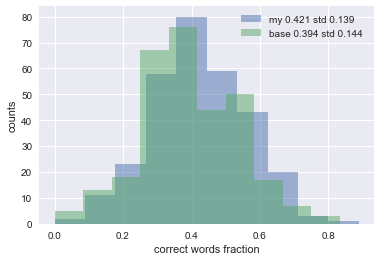

In [31]:
plt.clf()
plt.hist(my_rate, alpha=0.5, label="my %.3f std %.3f" % (np.mean(np.array(my_rate)), np.std(np.array(my_rate))))
plt.hist(base_rate, alpha=0.5, label="base %.3f std %.3f " % (np.mean(np.array(base_rate)), np.std(np.array(base_rate))))
plt.xlabel("correct words fraction")
plt.ylabel("counts")
plt.legend()
plt.show()

In [32]:
for i in [common_words_alltype, topic,  test_sumtoken, test_token]:
    print(" ".join(i))

come want right congress know time work day let year law house thing morning
congress time day right year law house thing morning news secretary afghanistan lot dot
united state strategy afghanistan congress able deliver president trump agenda continue fund government 20170424
good morning steve inskeep rachel bid monday april fourth word day news secretary jim medicine afghanistan recently giant strategy poutywhat entrance administration ambitious plan role government life day truly historic basis president congress lot lawmaker actually ahead decisive franciscosensual action sunday right nationalist fate political newcomer vote europe edge serb staff news chart support broadcast murder super krueger huhplus job site single clicking screen pirate right candidate fact free exit recruiter dot com slash outburst morgan stanley family financial adviser family togethermore ed morgan stanley dot com slash conversation morgan stanley barney l l c gun right let overseas scene long defense sec

In [35]:
lstm = "we need the last soul why her ideas for each for talks on the part of the asian will rise so the fall of tax on there . </t> <t> he says it 's not what was the result is a lie and left us is not rely with lots of life in cadiz that old rascal tax was a somewhat lowerlook who's the shuttle vulnerable . </t>"

In [36]:
lstm_token = lemming(nlp("".join(lstm)), doalpha=False, keeptype=[])

In [37]:
calc_score(ref=test_sumtoken, comp=lstm_token, debug=False)

0.04